Predict number of rented bikes using Linear and polynomial regression. Here I predict bike's number by using temperature information. Here I did not make the time series stationary.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import residuals_plot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import learning_curve

df1=pd.read_csv('day.csv', parse_dates=['dteday'])
df1

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Drop some unnecessary data

In [2]:
df1=df1.drop(['instant','casual','registered','season'], axis=1)

Plot histograms

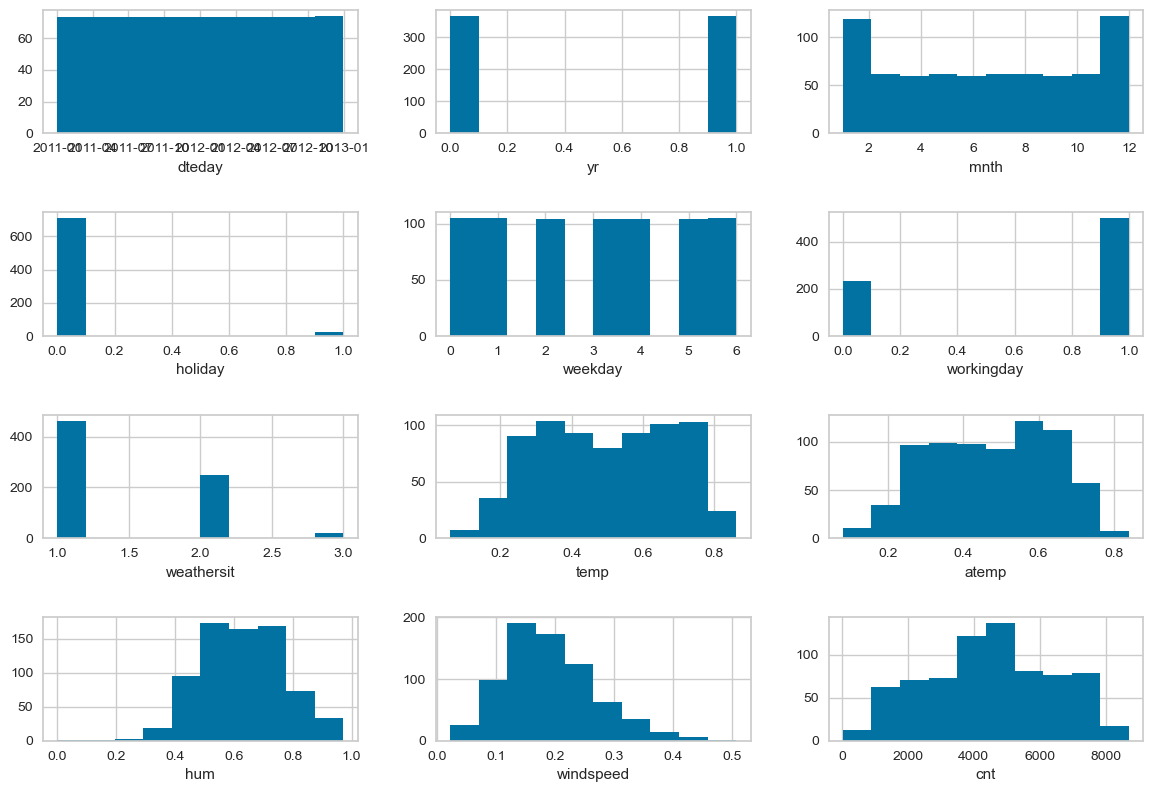

In [3]:
fig=plt.figure(figsize=(12,10))
count=0
for i in range(4):
    for j in range(3):
        plt.subplot2grid((5,3),(i,j))
        plt.hist(df1[df1.columns[count]])
        plt.xlabel(df1.columns[count])
        plt.tight_layout(pad=2)
        count+=1


Plot box

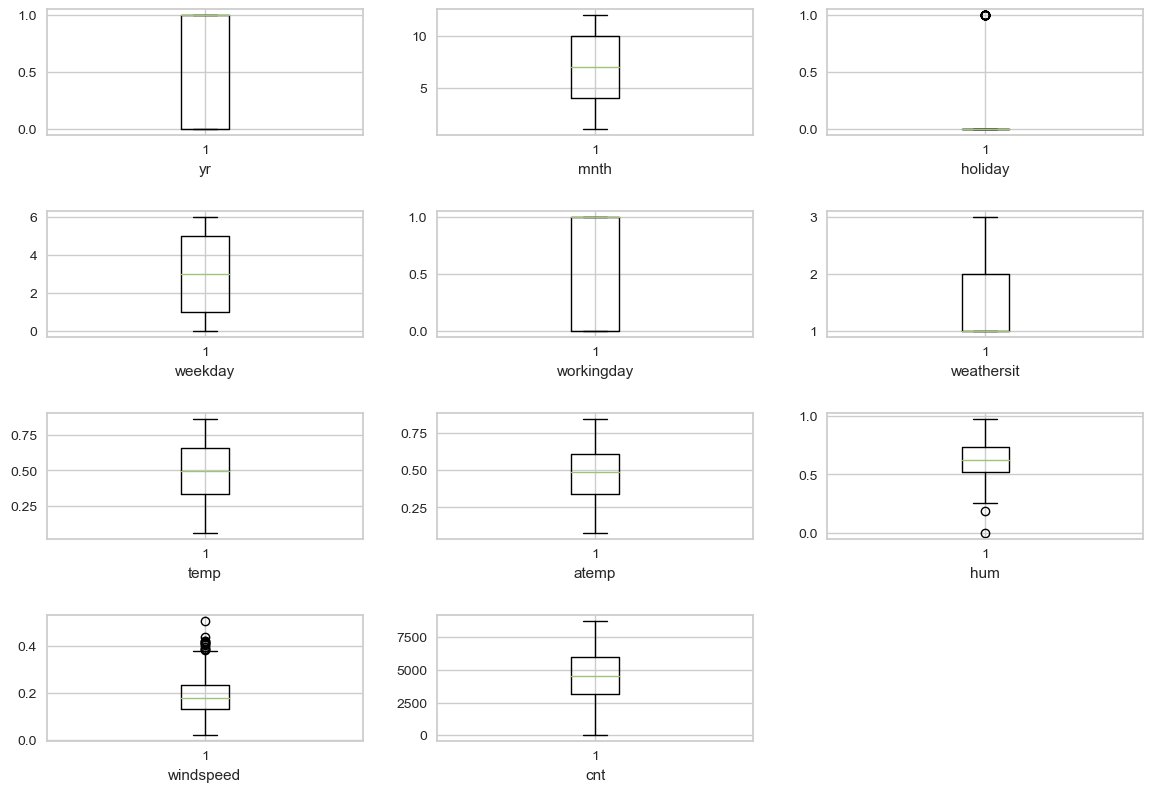

In [4]:
fig=plt.figure(figsize=(12,10))
count=1
for i in range(4):
    for j in range(3):
        if count== 12:
            break
        plt.subplot2grid((5,3),(i,j))
        plt.boxplot(df1[df1.columns[count]])
        plt.xlabel(df1.columns[count])
        plt.tight_layout(pad=2)
        count+=1

Remove outliers of windspeed and humidity

In [5]:
def outliers_idr(df):
    
    num=df.count(axis=1)
    num_col=num[1]
    
    i=0
    for colu in df:
        if (colu =='windspeed') | (colu== 'hum'):
            mean_df=df[colu].mean()
            std_df=df[colu].std()
            df_out= df[(df[colu] <= 3*std_df+mean_df) & (df[colu] >= (mean_df-3*std_df))]
            df=df_out
            i=i+1
        
    return df_out

df_r= outliers_idr(df1)
df_r

,dteday,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2011-01-01,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,2011-01-02,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,2011-01-03,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,2011-01-04,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,2011-01-05,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
726,2012-12-27,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,2114
727,2012-12-28,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,3095
728,2012-12-29,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,1341
729,2012-12-30,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,1796


Plot again box plots 

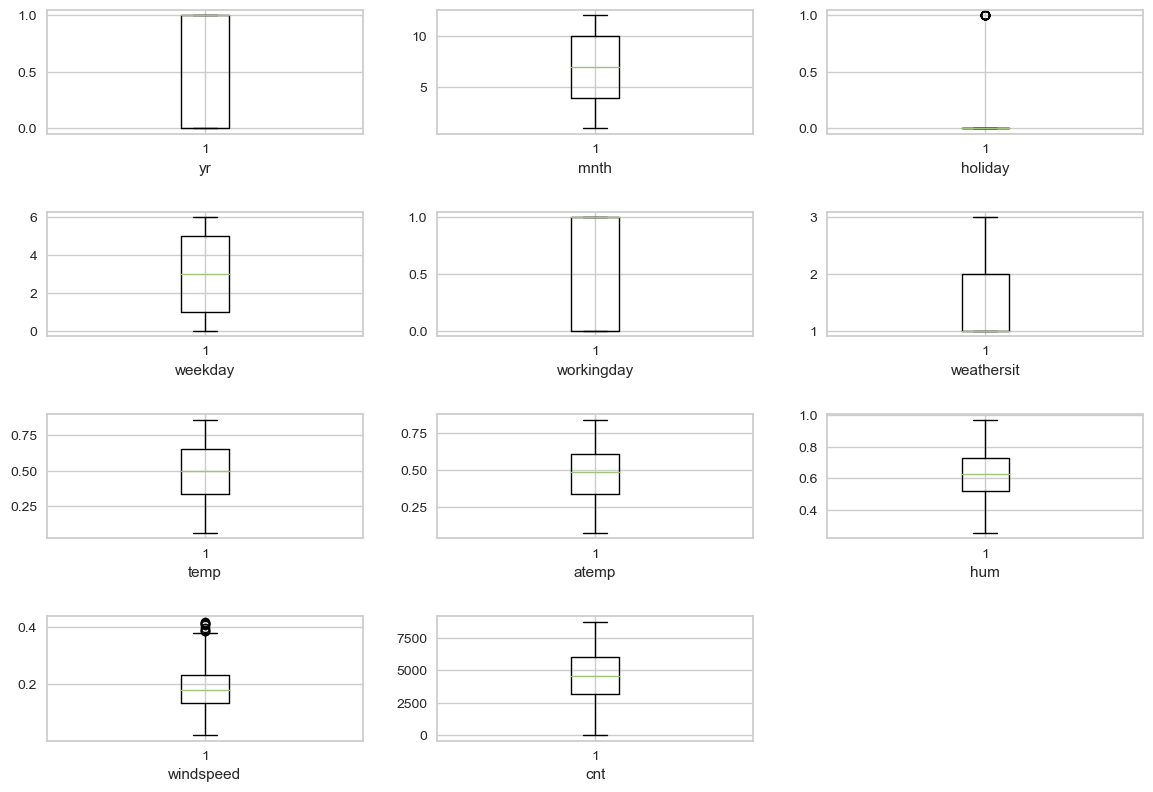

In [6]:
fig=plt.figure(figsize=(12,10))
count=1
for i in range(4):
    for j in range(3):
        if count== 12:
            break
        plt.subplot2grid((5,3),(i,j))
        plt.boxplot(df_r[df_r.columns[count]])
        plt.xlabel(df_r.columns[count])
        plt.tight_layout(pad=2)
        count+=1

Check if there is any duplicated data

In [7]:
df_r.duplicated().sum()

0

Check if there is any nun value

In [8]:
df_r.isna().sum()

dteday        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

Plot heatmap of correlation between features. As expected there is a large corelation between temperature and apperent temperature

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_24666/2129500185.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(cor, dtype=np.bool))


<AxesSubplot:>

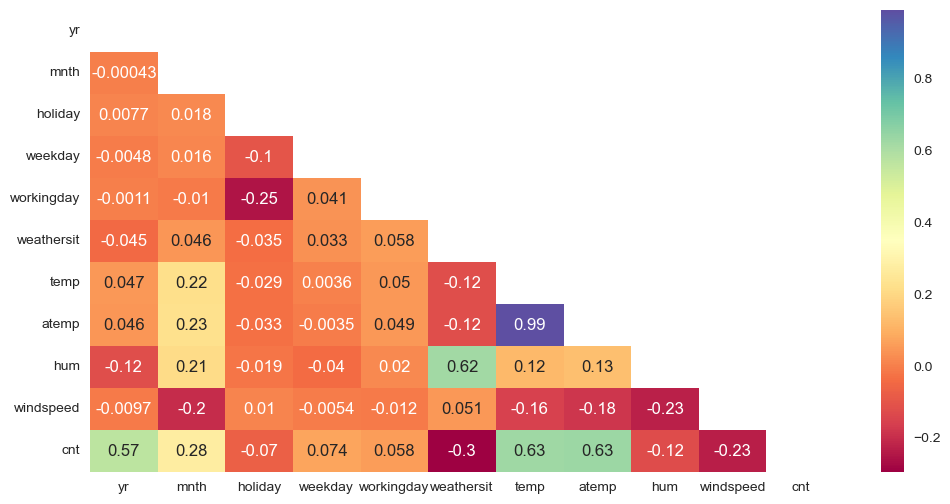

In [9]:
cor=df_r.corr()
mask = np.triu(np.ones_like(cor, dtype=np.bool))
fig=plt.figure(figsize=(12,6))
sns.heatmap(cor,cmap='Spectral', mask=mask , annot=True)


Let's drop atemp from dataset and start spliting the data

In [10]:
df_r=df_r.drop('atemp',axis=1)


In [11]:
df_r['dteday'].describe()

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_24666/1649262167.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_r['dteday'].describe()


count                     726
unique                    726
top       2011-01-01 00:00:00
freq                        1
first     2011-01-01 00:00:00
last      2012-12-31 00:00:00
Name: dteday, dtype: object

I select the train to be from the first of 2011 till first of May 2012 and the rest of months of 2021 serves as test dataset

In [12]:
df_r=df_r.set_index('dteday')

In [13]:
df_r

,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
dteday,,,,,,,,,,
2011-01-01,0,1,0,6,0,2,0.344167,0.805833,0.160446,985
2011-01-02,0,1,0,0,0,2,0.363478,0.696087,0.248539,801
2011-01-03,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349
2011-01-04,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562
2011-01-05,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600
...,...,...,...,...,...,...,...,...,...,...
2012-12-27,1,12,0,4,1,2,0.254167,0.652917,0.350133,2114
2012-12-28,1,12,0,5,1,2,0.253333,0.590000,0.155471,3095
2012-12-29,1,12,0,6,0,2,0.253333,0.752917,0.124383,1341


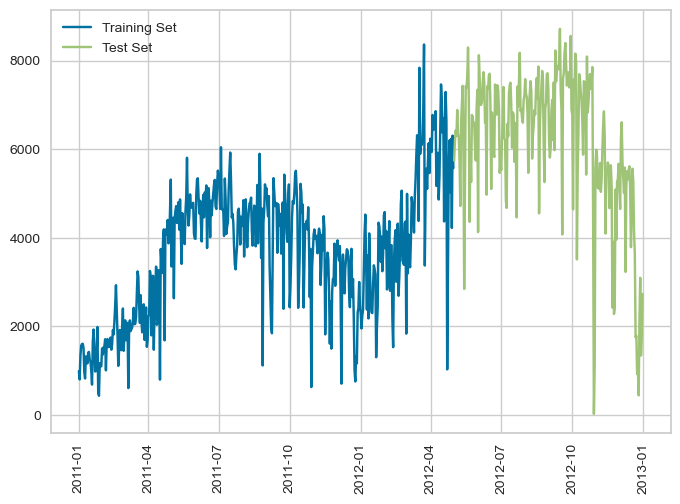

In [14]:
train=df_r[df_r.index < '05-01-2012']
test= df_r[df_r.index >= '05-01-2012']
plt.plot(train.index, train['cnt'])
plt.plot(test.index, test['cnt'])
plt.xticks(rotation=90)
plt.legend(['Training Set', 'Test Set'])

plt.show()

Plotting cross-validation 

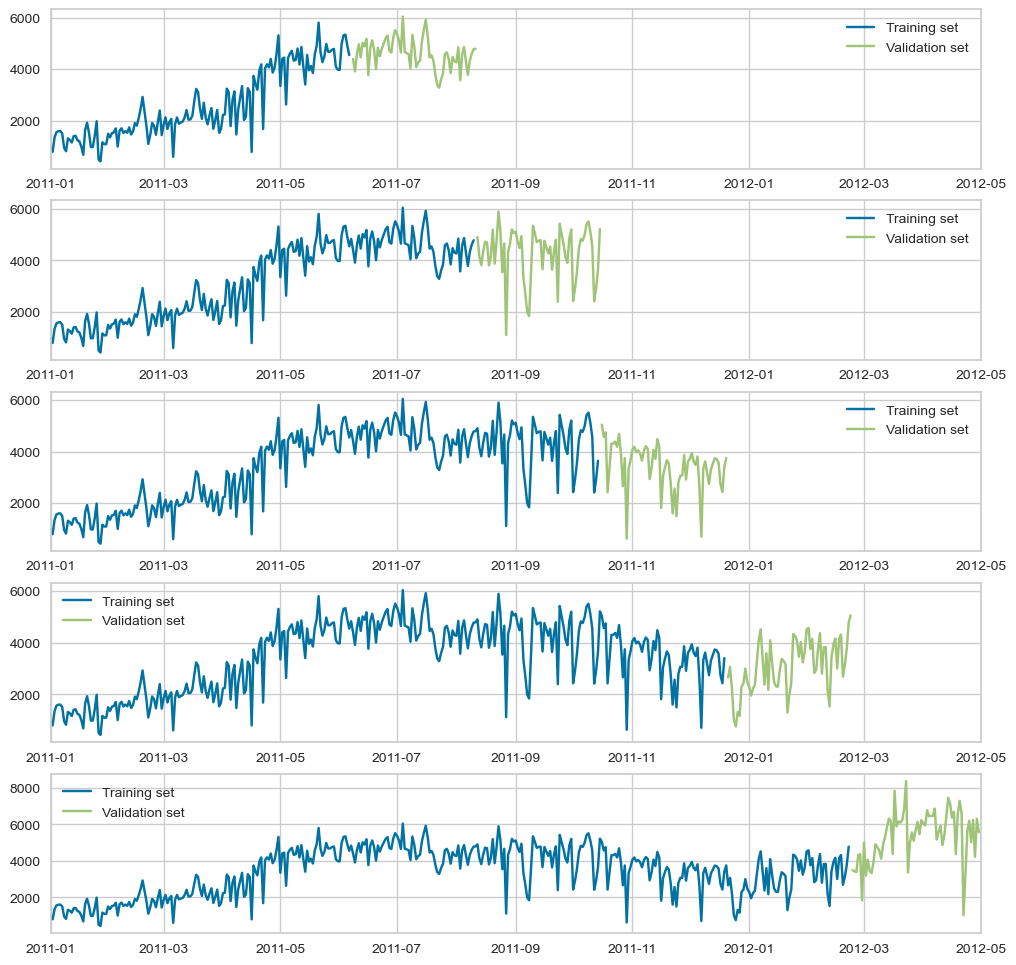

In [15]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()
fig=plt.figure(figsize=(12,12))

count=0
for train_in, val_in in cross_val.split(train):
    train_valid=df_r.iloc[train_in]
    validation=df_r.iloc[val_in]
    plt.subplot2grid((5,1),(count,0))
    plt.plot(train_valid.index, train_valid['cnt'])
    plt.plot(validation.index,validation['cnt'])
    plt.legend(['Training set','Validation set'])
    plt.xlim([dt.date(2011, 1, 1), dt.date(2012, 5, 1)])
    count+=1

plt.show()

code for plotting learning curve

In [16]:
# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 20)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
        
    x1 = np.linspace(0, 10, 8, endpoint=True) produces
        8 evenly spaced points in the range 0 to 10
    """
    
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring= "neg_mean_absolute_error")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylabel('neg_mean_absolute_error')

    plt.legend(loc="best")
    return plt

Define x and y and fit the model and find MSE and R2 scores

MAE is 760.9254
R square is 0.7661
MAE is 870.9661
R square is 0.7693
MAE is 1097.9505
R square is 0.6964
MAE is 983.2274
R square is 0.5956
MAE is 2161.1744
R square is 0.5358


<module 'matplotlib.pyplot' from '/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

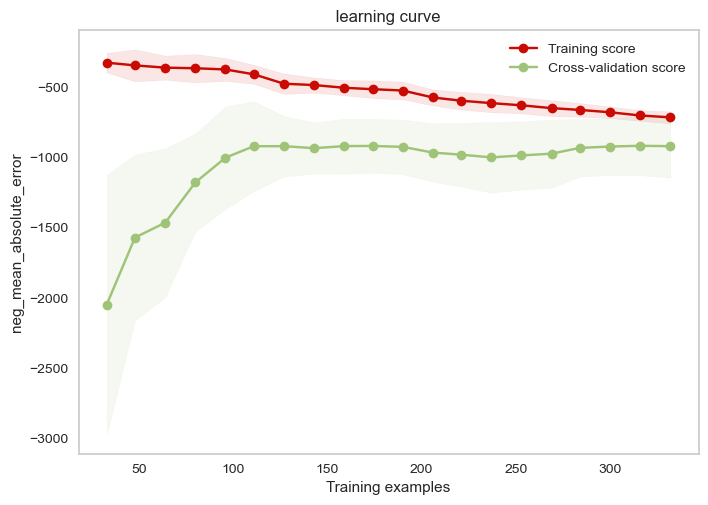

In [17]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    y_train=train_valid['cnt'].values.reshape(-1,1)
    y_val=validation['cnt'].values.reshape(-1,1)
    x_train=train_valid.temp.values.reshape(-1,1)
    x_val=validation.temp.values.reshape(-1,1)
    model=LinearRegression()
    model.fit(x_train, y_train)
    print('MAE is {}'.format('%.4f' %mean_absolute_error(y_val, model.predict(x_val)) ))
    print('R square is {}'.format('%.4f' %model.score(x_train,y_train)))
plot_learning_curve(estimator = model,title = " learning curve ",X = x_train, y = y_train, cv = 5)



Applying the model to the whole train data and getting score

In [18]:
x_train_total=train.temp.values.reshape(-1,1)
y_train_total=train['cnt'].values.reshape(-1,1)
x_test=test.temp.values.reshape(-1,1)
y_test=test['cnt'].values.reshape(-1,1)
model.fit(x_train, y_train)
y_pred=model.predict(x_test)
print('MAE is {}'.format('%.4f' %mean_absolute_error(y_test, model.predict(x_test)) ))
print('R square of traing data is {}'.format('%.4f' %model.score(x_train_total,y_train_total)))
print('R square of test data is {}'.format('%.4f' %r2_score(y_test, model.predict(x_test))))

MAE is 2365.3309
R square of traing data is 0.3506
R square of test data is -1.6121


Plotting fitted line

Text(0.5, 0, 'Normalised temperature (c°)')

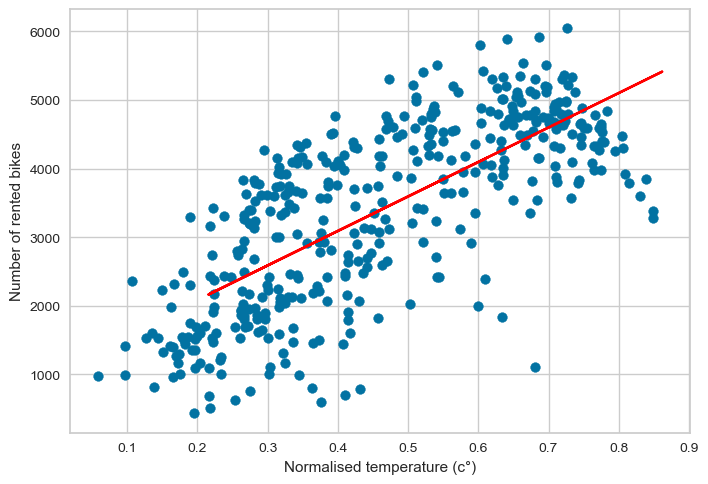

In [19]:
plt.scatter(x_train, y_train)
plt.plot(x_test,y_pred, color='red')
plt.ylabel('Number of rented bikes')
plt.xlabel('Normalised temperature (c°)')

Visialization of residuals

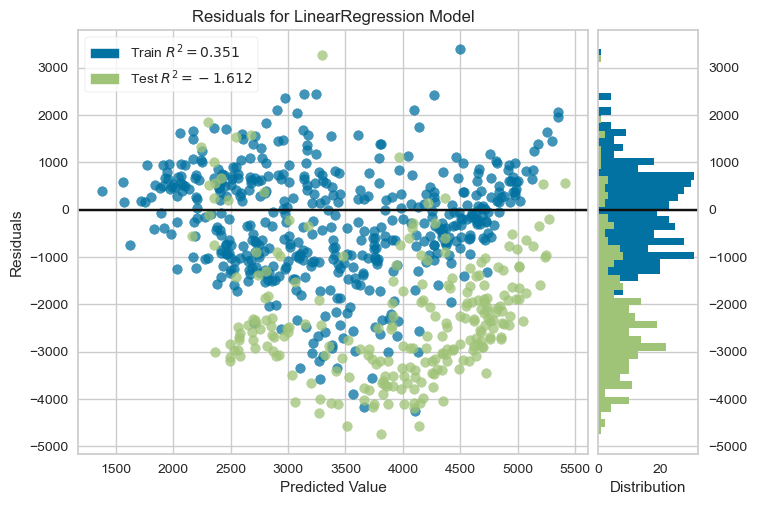

In [20]:
viz = residuals_plot(model, x_train_total, y_train_total, x_test, y_test)


Let's try polynomial regresion

830.124161577256
816.6093506665976
1002.5652648615364
1042.2493697926698
1971.1285220445122


<module 'matplotlib.pyplot' from '/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

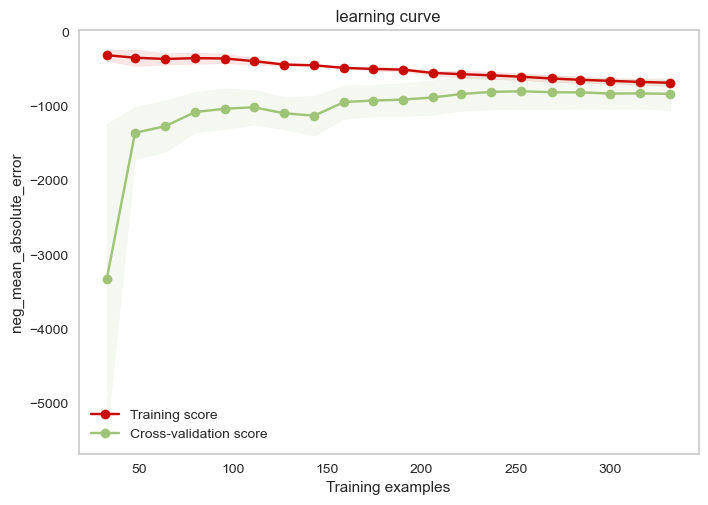

In [21]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    y_train=train_valid['cnt'].values.reshape(-1,1)
    y_val=validation['cnt'].values.reshape(-1,1)
    x_train=train_valid.temp.values.reshape(-1,1)
    x_val=validation.temp.values.reshape(-1,1)
    model_poly=PolynomialFeatures(degree=2)
    x_pl=model_poly.fit_transform(x_train)
    x_pl_val=model_poly.fit_transform(x_val)
    model_poly=LinearRegression()
    model_poly.fit(x_pl, y_train)
    y_pred=model_poly.predict(x_pl_val)
    print(mean_absolute_error(y_val, y_pred))
plot_learning_curve(estimator = model_poly,title = " learning curve ",X = x_pl, y = y_train, cv = 5)
 


Applying the model to the whole train data and getting score

In [22]:
x_train_total=train.temp.values.reshape(-1,1)
y_train_total=train['cnt'].values.reshape(-1,1)
x_test=test.temp.values.reshape(-1,1)
y_test=test['cnt'].values.reshape(-1,1)
model_poly=PolynomialFeatures(degree=2)
x_pl=model_poly.fit_transform(x_train_total)
x_pl_test=model_poly.fit_transform(x_test)
model_poly=LinearRegression()
model_poly.fit(x_pl, y_train_total)
y_pred=model_poly.predict(x_pl_test)
print(mean_absolute_error(y_test, y_pred))
print('R square of test data is {}'.format('%.4f' %r2_score(y_test, y_pred)))

2147.2252356726885
R square of test data is -1.1078


Plotting fitted curve 

Text(0.5, 0, 'Normalised temperature (c°)')

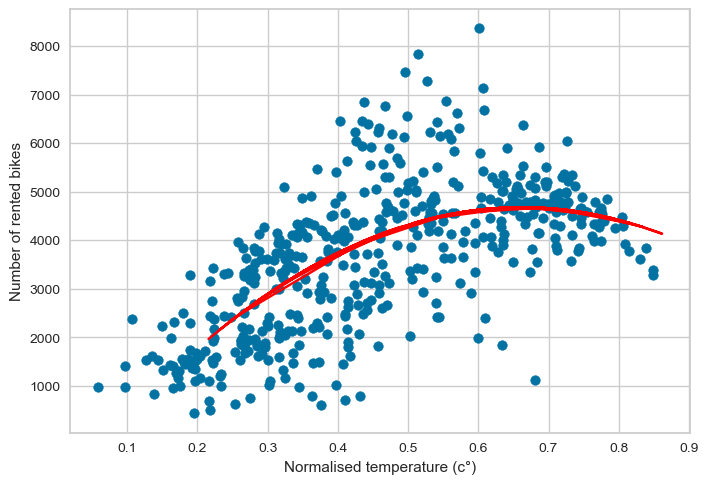

In [23]:
plt.scatter(x_train_total, y_train_total)
plt.plot(x_test,y_pred, color='red')
plt.ylabel('Number of rented bikes')
plt.xlabel('Normalised temperature (c°)')

Plotting residuals

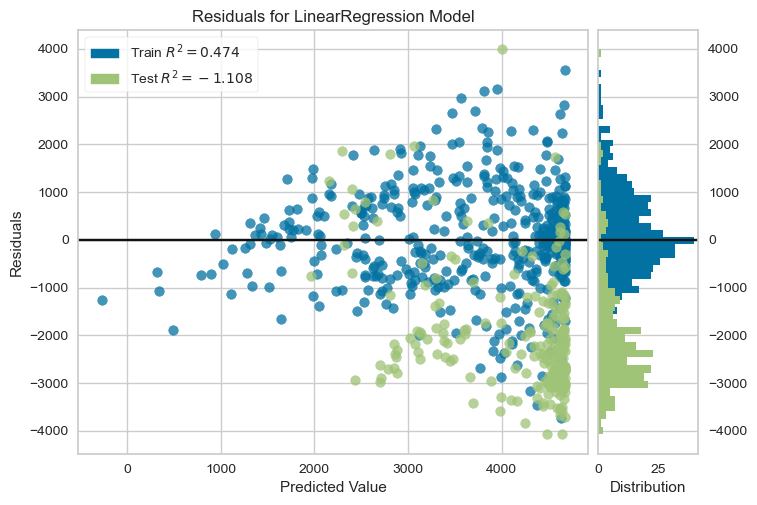

In [24]:
viz = residuals_plot(model_poly, x_pl, y_train_total, x_pl_test, y_test)


Plot prediction vs obsertionans

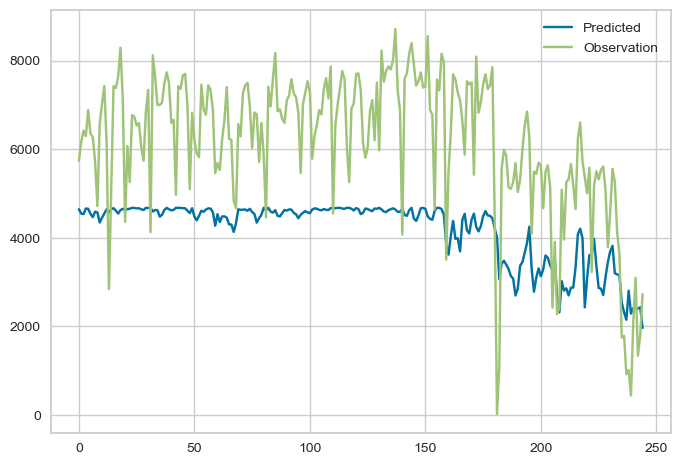

In [31]:
plt.plot(y_pred)
plt.plot(y_test)
plt.legend(['Predicted', 'Observation'])
plt.show()